# IBM Advance Datascience Specialization - Capstone Project [Deep Learning]

#### Dataset Details: Real World Car Insurance Fraud Dataset - Non Synthetic.
Source: Kaggle<br>
URL : https://www.kaggle.com/datasets/incarnyx/car-insurance-fraud<br>
DataSet Description: https://www.kaggle.com/datasets/incarnyx/car-insurance-fraud/discussion/133719 <br>
Dataset More Information: https://sites.google.com/site/cliftonphua/publications?authuser=0

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 
from silence_tensorflow import silence_tensorflow
silence_tensorflow()


In [3]:
%matplotlib ipympl

In [4]:
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, IncrementalPCA
from sklearn.manifold import TSNE
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, \
     RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import auc, roc_curve, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import xgboost as xgb
import tensorflow as tf
import tfgraphviz as tfg
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Dropout, BatchNormalization, Add, InputLayer
from tensorflow.keras.metrics import mae, mse, Accuracy, AUC
import dill as pickle
import logging
logging.getLogger('tensorflow').disabled = True
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(3)

## Loading Data

In [7]:
df = pd.read_excel('./Dataset.xlsx', 
                   sheet_name = 'Sheet1')

### Class Imbalance

In [8]:
lPos_class = [0.0 if i == False else 1.0 for i in (df['FraudFound_P'] == 1)]
nPos_class = sum(lPos_class)
nNeg_class = len(df.index) - nPos_class
np_weightR = nNeg_class/nPos_class

print("Number of Positive Class Data points =", nPos_class)
print("Number of Negative Class Data points =", nNeg_class)
print("Neg/pos weight ratio =", np_weightR)
print("Percentage of Positive Class =", nPos_class*100/(nPos_class+nNeg_class))
print("Percentage of Negative Class =", nNeg_class*100/(nPos_class+nNeg_class))

class_Weights = {0:(1 / nNeg_class) * (len(df.index) / 2.0), 1:(1 / nPos_class) * (len(df.index) / 2.0)}
print("Class weights =", class_Weights)

Number of Positive Class Data points = 685.0
Number of Negative Class Data points = 10880.0
Neg/pos weight ratio = 15.883211678832117
Percentage of Positive Class = 5.923043666234328
Percentage of Negative Class = 94.07695633376568
Class weights = {0: 0.5314797794117647, 1: 8.441605839416058}


## PART2: Deep Learning Models

#### Data Preparation and Scaling

In [12]:

df_encoded_d = df.drop(['PolicyNumber'], axis=1)
df_encoded_d['LogClaimSize'] = np.log(df_encoded_d.pop('ClaimSize')+0.001)
mean_age = df_encoded_d['Age'].mean()
df_encoded_d['Age'] = df_encoded_d['Age'].fillna(mean_age)
mean_DriverRating = df_encoded_d['DriverRating'].mean()
df_encoded_d['DriverRating'] = df_encoded_d['DriverRating'].fillna(mean_DriverRating)
df_encoded_d = df_encoded_d.dropna().reset_index(drop=True)
df_encoded_d.name = "Insurance Fraud Data"


label_encoder = preprocessing.LabelEncoder()

cols_to_encode = ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'BasePolicy', \
                   'NumberOfCars', 'AddressChange_Claim', 'NumberOfSuppliments', 'WitnessPresent', 'PoliceReportFiled', \
                   'AgeOfPolicyHolder', 'AgeOfVehicle', 'Days_Policy_Claim', 'Days_Policy_Accident', 'PastNumberOfClaims', \
                   'Sex', 'MaritalStatus', 'AgentType', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice']

for col in cols_to_encode:
    df_encoded_d[col] = label_encoder.fit_transform(df_encoded_d[col].astype(str))

X_d = df_encoded_d.drop('FraudFound_P', axis = 1).values
y_d = df_encoded_d['FraudFound_P'].values

X_train, X_test, y_train, y_test = train_test_split(
                    X_d, y_d, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



### Basic Sequential Model

In [29]:
model_file = "Seq_keras.h5"

initial_bias = np.log([nPos_class/(nNeg_class)])
initial_bias = initial_bias *0.00001

# Build the Sequential feedforward neural network model
model = Sequential([
                   Dense(64, activation ='relu', kernel_initializer='normal', input_shape=(32,)),
                   BatchNormalization(synchronized=True),
                   Dropout(0.6),
                   Dense(128, activation ='relu', kernel_initializer='normal'),
                   BatchNormalization(synchronized=True),    
                   Dropout(0.6),
                   Dense(64, activation ='relu', kernel_initializer='normal'),
                   BatchNormalization(synchronized=True),    
                   Dropout(0.6),
                   Dense(1, activation ='sigmoid', kernel_initializer='normal'),
                  ])


opt=tf.keras.optimizers.Adam(learning_rate=0.00045)
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

lf= keras.losses.BinaryCrossentropy(from_logits=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max', 
                    patience = 10, restore_best_weights = False)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_accuracy", mode="max", 
                    save_best_only=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.9,
                              patience=5, min_lr=0.000001,verbose=1)
model.compile(optimizer=opt,
               loss=lf,
               metrics=METRICS
               )

wt9 = model.layers[9].get_weights()
wt9[1]= initial_bias
model.layers[9].set_weights(wt9)

history = model.fit(x=X_train[...,np.newaxis], y=y_train, validation_data=(X_test[..., np.newaxis], y_test),
                     class_weight = class_Weights, epochs=300, batch_size=2048, verbose=2, callbacks=[reduce_lr,early_stop, checkpoint])

#Load the history into a pandas Dataframe
df_hist = pd.DataFrame(history.history)
model.load_weights(model_file)

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.48725, saving model to Seq_keras.h5
5/5 - 5s - loss: 0.7549 - cross entropy: 0.7353 - Brier score: 0.2663 - tp: 240.0000 - fp: 4172.0000 - tn: 4531.0000 - fn: 309.0000 - accuracy: 0.5157 - precision: 0.0544 - recall: 0.4372 - auc: 0.4717 - prc: 0.0556 - val_loss: 0.6932 - val_cross entropy: 0.6932 - val_Brier score: 0.2500 - val_tp: 88.0000 - val_fp: 1138.0000 - val_tn: 1039.0000 - val_fn: 48.0000 - val_accuracy: 0.4872 - val_precision: 0.0718 - val_recall: 0.6471 - val_auc: 0.5229 - val_prc: 0.0679 - lr: 4.5000e-04 - 5s/epoch - 901ms/step
Epoch 2/300

Epoch 2: val_accuracy improved from 0.48725 to 0.65024, saving model to Seq_keras.h5
5/5 - 0s - loss: 0.7269 - cross entropy: 0.7326 - Brier score: 0.2655 - tp: 285.0000 - fp: 4169.0000 - tn: 4534.0000 - fn: 264.0000 - accuracy: 0.5209 - precision: 0.0640 - recall: 0.5191 - auc: 0.5160 - prc: 0.0607 - val_loss: 0.6921 - val_cross entropy: 0.6921 - val_Brier score: 0.2495 - val_tp

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)              

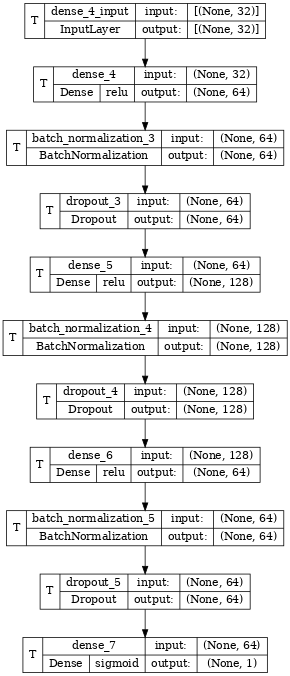

In [16]:
tf.keras.utils.plot_model(model, dpi=55, show_layer_activations=True,show_trainable=True,
                          show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB',
                          expand_nested=True)

In [30]:
df_hist.tail(10)

,loss,cross entropy,Brier score,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_cross entropy,val_Brier score,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc,lr
11,0.672258,0.718236,0.258096,362.0,3962.0,4741.0,187.0,0.551556,0.083719,0.659381,0.639644,0.092831,0.662794,0.662794,0.234834,16.0,39.0,2138.0,120.0,0.931258,0.290909,0.117647,0.767989,0.183019,0.000450
12,0.641145,0.706899,0.253279,410.0,3931.0,4772.0,139.0,0.560095,0.094448,0.746812,0.692471,0.115114,0.658832,0.658832,0.232857,16.0,44.0,2133.0,120.0,0.929096,0.266667,0.117647,0.767654,0.175880,0.000450
13,0.649369,0.716107,0.255823,388.0,3889.0,4814.0,161.0,0.562257,0.090718,0.706740,0.685244,0.105574,0.653704,0.653704,0.230301,18.0,44.0,2133.0,118.0,0.929961,0.290323,0.132353,0.780053,0.177587,0.000450
14,0.654079,0.716470,0.256433,396.0,3929.0,4774.0,153.0,0.558798,0.091561,0.721311,0.675870,0.103312,0.649595,0.649595,0.228255,19.0,49.0,2128.0,117.0,0.928232,0.279412,0.139706,0.777318,0.180842,0.000450
15,0.648322,0.715311,0.254733,392.0,3800.0,4903.0,157.0,0.572309,0.093511,0.714025,0.688142,0.108141,0.645250,0.645250,0.226095,21.0,58.0,2119.0,115.0,0.925205,0.265823,0.154412,0.780998,0.172579,0.000450
16,0.623745,0.706837,0.251387,426.0,3769.0,4934.0,123.0,0.579334,0.101549,0.775956,0.725105,0.125786,0.641092,0.641092,0.224030,22.0,69.0,2108.0,114.0,0.920882,0.241758,0.161765,0.785371,0.176266,0.000405
17,0.623826,0.711800,0.252996,415.0,3778.0,4925.0,134.0,0.577173,0.098974,0.755920,0.726109,0.126597,0.638006,0.638006,0.222503,31.0,99.0,2078.0,105.0,0.911803,0.238462,0.227941,0.783232,0.171567,0.000405
18,0.624225,0.715043,0.254615,421.0,3820.0,4883.0,128.0,0.573281,0.099269,0.766849,0.720332,0.125604,0.634912,0.634912,0.220975,32.0,131.0,2046.0,104.0,0.898400,0.196319,0.235294,0.786120,0.175719,0.000405
19,0.628961,0.712707,0.253473,417.0,3796.0,4907.0,132.0,0.575443,0.098979,0.759563,0.714795,0.123080,0.631457,0.631457,0.219270,34.0,154.0,2023.0,102.0,0.889321,0.180851,0.250000,0.786592,0.174594,0.000405
20,0.617576,0.715906,0.254705,429.0,3802.0,4901.0,120.0,0.576092,0.101394,0.781421,0.733868,0.133474,0.628512,0.628512,0.217824,39.0,191.0,1986.0,97.0,0.875486,0.169565,0.286765,0.790399,0.177946,0.000405


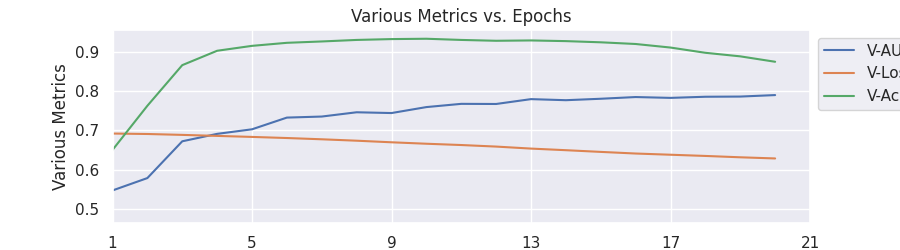

In [31]:
plt.figure(figsize = (9, 2.5))
sns.set(style = "darkgrid")

plt.xlabel("Epochs")
plt.ylabel("Various Metrics")
plt.title("Various Metrics vs. Epochs")
plt.plot(df_hist.index, df_hist['val_auc'], label = "V-AUC")
plt.plot(df_hist.index, df_hist['val_loss'], label = "V-Loss")
plt.plot(df_hist.index, df_hist['val_accuracy'], label = "V-Accuracy")

plt.xticks(np.arange(1, 100, step=4))
plt.xlim(left=1, right=len(df_hist.index))
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [38]:
nm='Keras-Seq'
y_test_op = [1.0 if i > 0.5 else 0.0 for i in model.predict(X_test)]
accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
b_acc = balanced_accuracy_score(y_test, y_test_op)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)
print("Balanced Accuracy on test data for Keras-Seq model =", b_acc)

73/73 [==============================] - 0s 2ms/step
Report on test data for  Keras-Seq 
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      2267
         1.0       0.11      0.33      0.16        46

    accuracy                           0.93      2313
   macro avg       0.55      0.64      0.57      2313
weighted avg       0.97      0.93      0.95      2313

Accuracy on test data for  Keras-Seq : 0.9342844790315608
Balanced Accuracy on test data for Keras-Seq model = 0.5480271690669837


### Experimetal Model With Three Chained Resnet Blocks Adapted For Classification

In [20]:
ip = keras.Input(shape=(32,))

D0 = Dense(128, activation =None, kernel_initializer='normal')(ip)
A0 = tf.nn.relu(D0)
B0 = BatchNormalization(synchronized=True)(A0)
DP0 = Dropout(0.6)(B0)

### Resnet Block 1 - Begin
D1 = Dense(128, activation =None, kernel_initializer='normal')(DP0)
A1 = tf.nn.relu(D1)
B1 = BatchNormalization(synchronized=True)(A1)
DP1 = Dropout(0.6)(B1)

D1a = Dense(128, activation =None, kernel_initializer='normal')(DP1)
DP1a = Dropout(0.6)(D1a)
S1a = tf.add(DP0, DP1a)
A1a = tf.nn.relu(S1a)
B1 = BatchNormalization(synchronized=True)(A1a)
DP1_op = Dropout(0.6)(B1)
### Resnet Block 1 - End

### Resnet Block 2 - Begin
D2 = Dense(128, activation =None, kernel_initializer='normal')(DP1_op)
S2a = tf.add(DP1, D2)
A2 = tf.nn.relu(S2a)
B2a = BatchNormalization(synchronized=True)(A2)
DP2 = Dropout(0.6)(B2a)

D2a = Dense(128, activation =None, kernel_initializer='normal')(DP2)
DP2a = Dropout(0.6)(D2a)
S2b = tf.add(DP1_op, DP2a)
A2a = tf.nn.relu(S2b)
B2 = BatchNormalization(synchronized=True)(A2a)
DP2_op = Dropout(0.6)(B2)
### Resnet Block 2 - End

op = Dense(1, activation ='sigmoid', kernel_initializer='normal')(DP2_op)
                  
# Build the Sequential feedforward neural network model
model_r = keras.Model(inputs=ip, outputs=op, name="Resnet-1")

In [21]:
model_r.summary()

Model: "Resnet-1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 128)                  4224      ['input_1[0][0]']             
                                                                                                  
 tf.nn.relu (TFOpLambda)     (None, 128)                  0         ['dense_8[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 128)                  512       ['tf.nn.relu[0][0]']          
 chNormalization)                                                                          

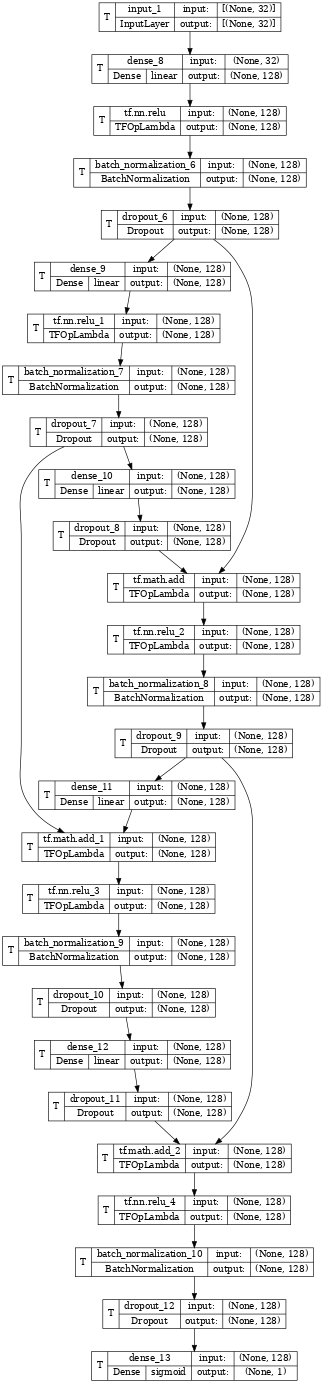

In [22]:
tf.keras.utils.plot_model(model_r, dpi=45, show_layer_activations=True,show_trainable=True,
                          show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB',
                          expand_nested=True)

In [45]:
model_file='Keras_resnet'

opt=tf.keras.optimizers.Adam(learning_rate=0.005)
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
lf= keras.losses.BinaryCrossentropy(from_logits=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max', 
                    patience = 50, restore_best_weights = False)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_accuracy", mode="max", 
                    save_best_only=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.2,
                              patience=5, min_lr=0.000001,verbose=1)


model_r.compile(optimizer=opt,
               loss=lf, 
               metrics=METRICS)

initial_bias = 0.01* np.log([nPos_class/(nNeg_class)])
#initial_bias = initial_bias

wt9 = model.layers[-1].get_weights()
wt9[1]= initial_bias
model.layers[9].set_weights(wt9)

history = model_r.fit(x=X_train[...,np.newaxis], y=y_train, validation_data=(X_test[..., np.newaxis], y_test),
                    class_weight = class_Weights, epochs=300, batch_size=2048, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.69607, saving model to Keras_resnet
5/5 - 10s - loss: 0.4214 - cross entropy: 0.4672 - Brier score: 0.1724 - tp: 516.0000 - fp: 2777.0000 - tn: 5926.0000 - fn: 33.0000 - accuracy: 0.6963 - precision: 0.1567 - recall: 0.9399 - auc: 0.8617 - prc: 0.2336 - val_loss: 0.4277 - val_cross entropy: 0.4277 - val_Brier score: 0.1575 - val_tp: 108.0000 - val_fp: 675.0000 - val_tn: 1502.0000 - val_fn: 28.0000 - val_accuracy: 0.6961 - val_precision: 0.1379 - val_recall: 0.7941 - val_auc: 0.8029 - val_prc: 0.1918 - 10s/epoch - 2s/step
Epoch 2/300

Epoch 2: val_accuracy did not improve from 0.69607
5/5 - 0s - loss: 0.4271 - cross entropy: 0.4656 - Brier score: 0.1727 - tp: 513.0000 - fp: 2781.0000 - tn: 5922.0000 - fn: 36.0000 - accuracy: 0.6955 - precision: 0.1557 - recall: 0.9344 - auc: 0.8548 - prc: 0.2191 - val_loss: 0.4467 - val_cross entropy: 0.4467 - val_Brier score: 0.1653 - val_tp: 109.0000 - val_fp: 704.0000 - val_tn: 1473.0000 - va

In [46]:
# Load the history into a pandas Dataframe
model_r.load_weights(model_file)
df_hist = pd.DataFrame(history.history)
df_hist.head(10)

nm='Keras-Resnet'

y_test_op = [1.0 if i > 0.5 else 0.0 for i in model_r.predict(X_test)]

accr = accuracy_score(y_test_op, y_test)
rep = classification_report(y_test_op, y_test)
b_acc = balanced_accuracy_score(y_test, y_test_op)
print("Report on test data for ", nm, '\n', rep)
print("Accuracy on test data for ", nm, ":", accr)
print("Balanced Accuracy on test data for Keras-Seq model =", b_acc)

73/73 [==============================] - 0s 2ms/step
Report on test data for  Keras-Resnet 
               precision    recall  f1-score   support

         0.0       0.75      0.98      0.85      1661
         1.0       0.74      0.15      0.25       652

    accuracy                           0.75      2313
   macro avg       0.74      0.57      0.55      2313
weighted avg       0.74      0.75      0.68      2313

Accuracy on test data for  Keras-Resnet : 0.7457846952010376
Balanced Accuracy on test data for Keras-Seq model = 0.740867086384393


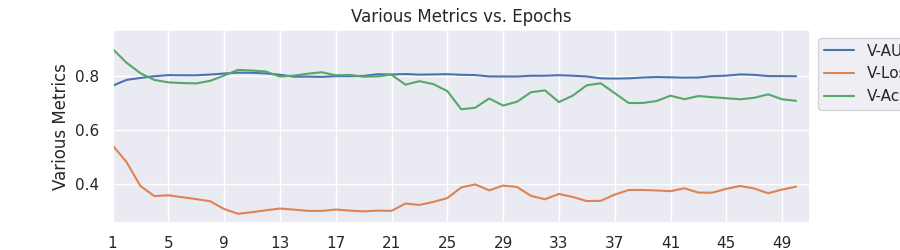

In [27]:
plt.figure(figsize = (9, 2.5))
sns.set(style = "darkgrid")

plt.xlabel("Epochs")
plt.ylabel("Various Metrics")
plt.title("Various Metrics vs. Epochs")
plt.plot(df_hist.index, df_hist['val_auc'], label = "V-AUC")
plt.plot(df_hist.index, df_hist['val_loss'], label = "V-Loss")
plt.plot(df_hist.index, df_hist['val_accuracy'], label = "V-Accuracy")

plt.xticks(np.arange(1, 100, step=4))
plt.xlim(left=1, right=len(df_hist.index))
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

### Conclusion - Deep learning

We see that the regular sequential deep learning model has test data accuracy (overall) = 0.93428 and test data balanced accuracy = 0.54802.<br>
And the Experimental Model With Three Chained Resnet Blocks test data accuracy (overall) = 0.7457 and test data balanced accuracy = 0.7408.<br>
Notable fact is the experimental resnet model though has overall low accuracy but it give the best balanced accuracy of all the ML and Dl model we have tried out.<br>
So if we can develop the experimental resnet model further it might give much better results for prediction of minority classes.<br>
But unfortunately this is beyond the scope of this project.